In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from data_utils import *
from datasets import *
from sklearn.metrics import mean_squared_error

############################# Place the games here ############################
train_game_names = ['Barbie', 'Kawaii_Fire_Station', 'Kawaii_Playroom', 'Kawaii_Police_Station']
test_game_names = ['Kawaii_House', 'Kawaii_Daycare']
val_game_names = ['Kawaii_House', 'Kawaii_Daycare']

In [19]:
######################### Place files for splits ##################################
######################### Must be similar to csv of predicted values ##################################
train_sessions = DataUtils.read_txt("/data/mala711/COMPSCI715/datasets/final_data_splits/train.txt")
val_sessions = DataUtils.read_txt("/data/mala711/COMPSCI715/datasets/final_data_splits/val.txt")
test_sessions = DataUtils.read_txt("/data/mala711/COMPSCI715/datasets/final_data_splits/test.txt")

col_pred = ["thumbstick_left_x", "thumbstick_left_y", "thumbstick_right_x", "thumbstick_right_y", "head_pos_x", "head_pos_y", "head_pos_z", "head_dir_a", "head_dir_b", "head_dir_c", "head_dir_d"]

train_set = MultiGameDataset(train_game_names, train_sessions, cols_to_predict=col_pred)
val_set = MultiGameDataset(val_game_names, val_sessions, cols_to_predict=col_pred)
test_set = MultiGameDataset(test_game_names, test_sessions, cols_to_predict=col_pred) 

# Normalisation
thumbsticks_loc = 6
head_pos_loc = 9

train_set.df[train_set.df.columns[2:thumbsticks_loc]] = (train_set.df[train_set.df.columns[2:thumbsticks_loc]] + 1) / 2
val_set.df[val_set.df.columns[2:thumbsticks_loc]] = (val_set.df[val_set.df.columns[2:thumbsticks_loc]] + 1) / 2
test_set.df[test_set.df.columns[2:thumbsticks_loc]] = (test_set.df[test_set.df.columns[2:thumbsticks_loc]] + 1) / 2

train_set.df[train_set.df.columns[thumbsticks_loc:head_pos_loc]] = (train_set.df[train_set.df.columns[thumbsticks_loc:head_pos_loc]] + 2) / 4
val_set.df[val_set.df.columns[thumbsticks_loc:head_pos_loc]] = (val_set.df[val_set.df.columns[thumbsticks_loc:head_pos_loc]] + 2) / 4
test_set.df[test_set.df.columns[thumbsticks_loc:head_pos_loc]] = (test_set.df[test_set.df.columns[thumbsticks_loc:head_pos_loc]] + 2) / 4

train_set.df[train_set.df.columns[head_pos_loc:]] = (train_set.df[train_set.df.columns[head_pos_loc:]] + 1) / 2
val_set.df[val_set.df.columns[head_pos_loc:]] = (val_set.df[val_set.df.columns[head_pos_loc:]] + 1) / 2
test_set.df[test_set.df.columns[head_pos_loc:]] = (test_set.df[test_set.df.columns[head_pos_loc:]] + 1) / 2

In [20]:
########################## File of csv predictions ##################################

pred_df = pd.read_csv("/data/mala711/COMPSCI715/CNNRNN/csv_files/GRU_CPCA_train_['Barbie', 'Kawaii_Fire_Station', 'Kawaii_Playroom', 'Kawaii_Police_Station']_test_['Kawaii_House', 'Kawaii_Daycare']_init_test_seq_size_50_seqstart_20_iter_10_reg_1e-05_lr_0.01_dropout_0.2_weighting_True.csv")

In [21]:
true_df = test_set.df

# Create ids for to filter rows
pred_df['full_name'] = pred_df['game_session'] + pred_df['frame'].astype(str)
true_df['full_name'] = true_df['game_session'] + true_df['frame'].astype(str)
mask = true_df['full_name'].isin(pred_df['full_name'])
filtered_df = true_df[mask]

fin_true_df = filtered_df.sort_values(by = ['game_session', 'frame'])
fin_true_df = fin_true_df.reset_index(drop='index')

fin_pred_df = pred_df.sort_values(by = ['game_session', 'frame'])
fin_pred_df = fin_pred_df.reset_index(drop='index')

# Get matrices for prediction
pred_mat = fin_pred_df.iloc[:, 2:-1].to_numpy()
true_mat = fin_true_df.iloc[:, 2:-1].to_numpy()

In [22]:
###################### Calculate MSE for control ######################
for i in range(11):
    mse = mean_squared_error(true_mat[:, i], pred_mat[:, i])
    c = i+2
    print(f'{fin_pred_df.columns[c]}: {mse}')

mean_squared_error(true_mat, pred_mat)

thumbstick_left_x: 0.020185859898394356
thumbstick_left_y: 0.13581040992267146
thumbstick_right_x: 0.003464585516024306
thumbstick_right_y: 0.0029046281251290827
head_pos_x: 0.012286956539777807
head_pos_y: 0.000442257758817895
head_pos_z: 0.004900525786956065
head_dir_a: 0.005515067151291351
head_dir_b: 0.05037971978902581
head_dir_c: 0.0008550253319451775
head_dir_d: 0.0045691611663612915


0.021937654271490418

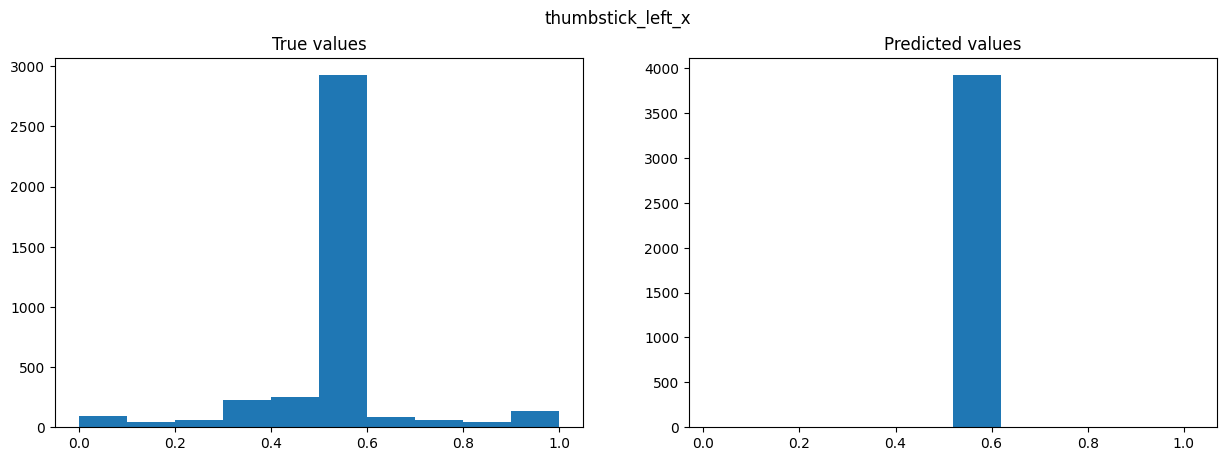

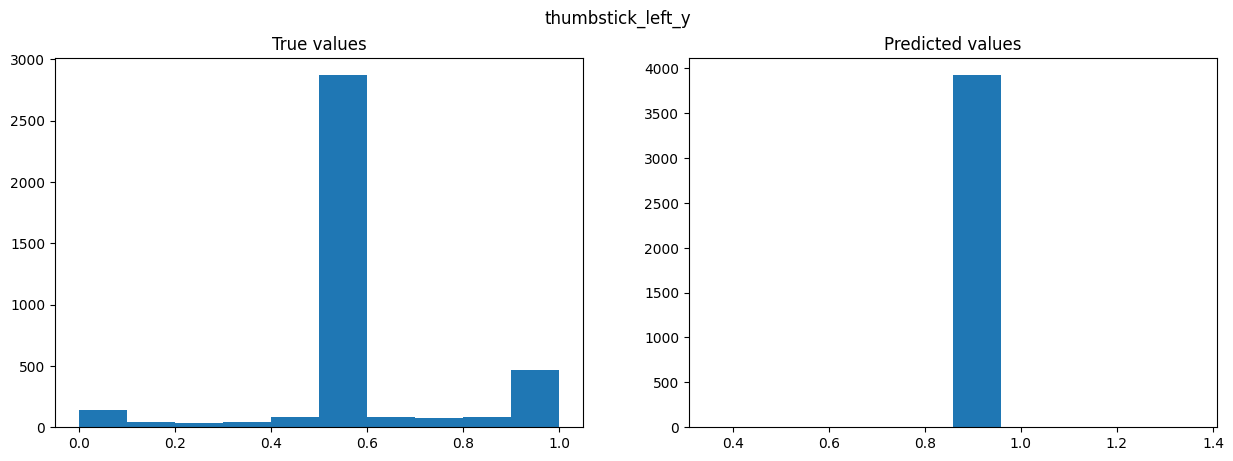

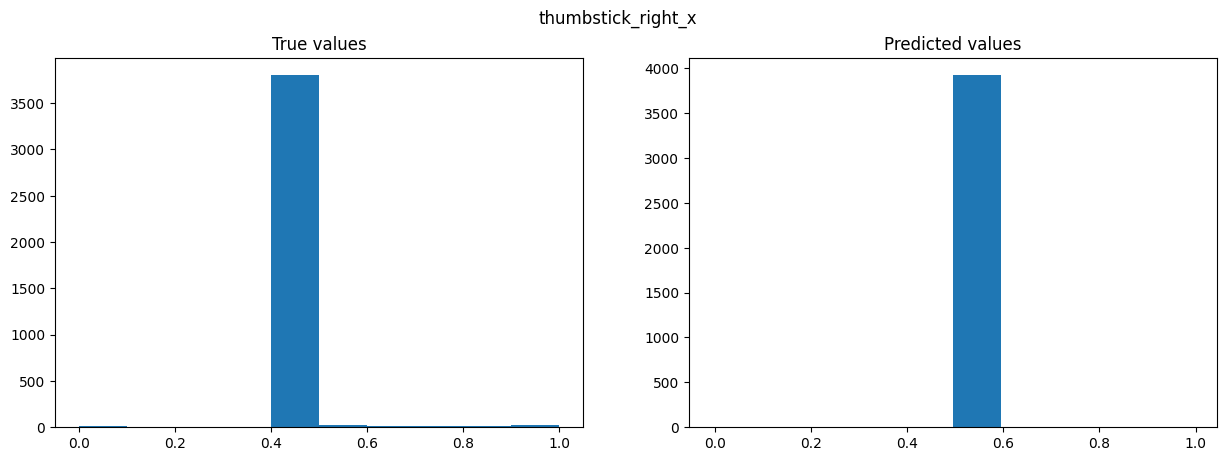

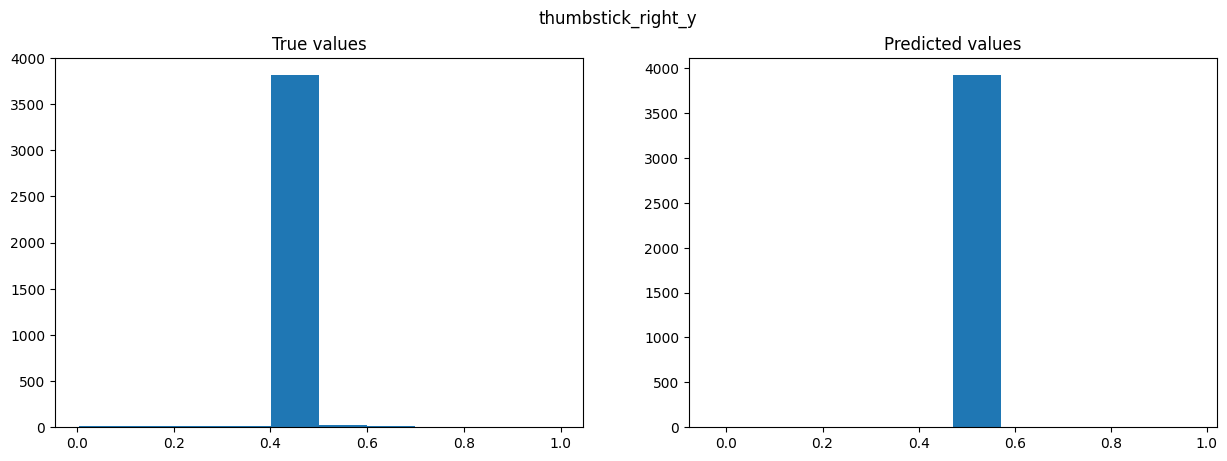

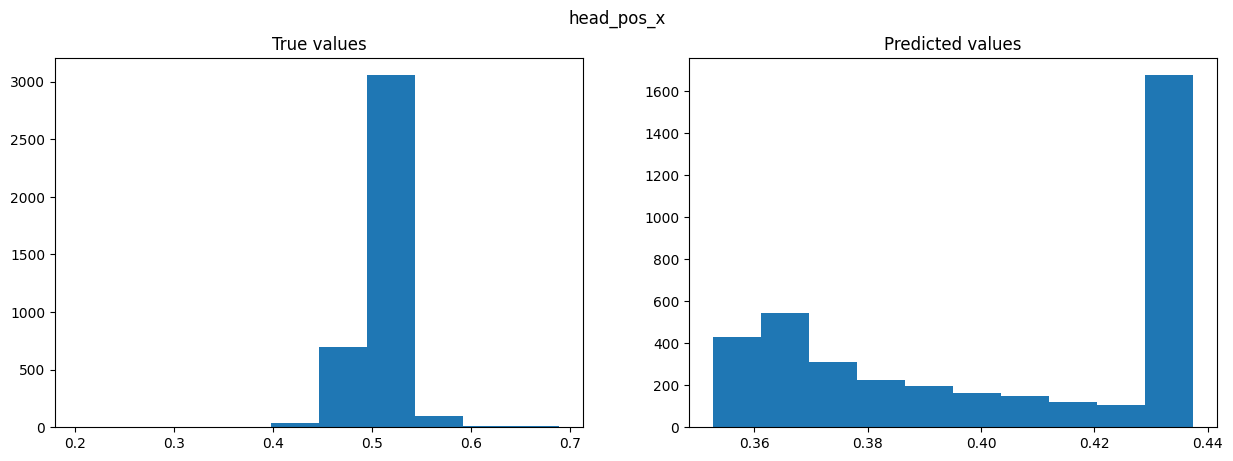

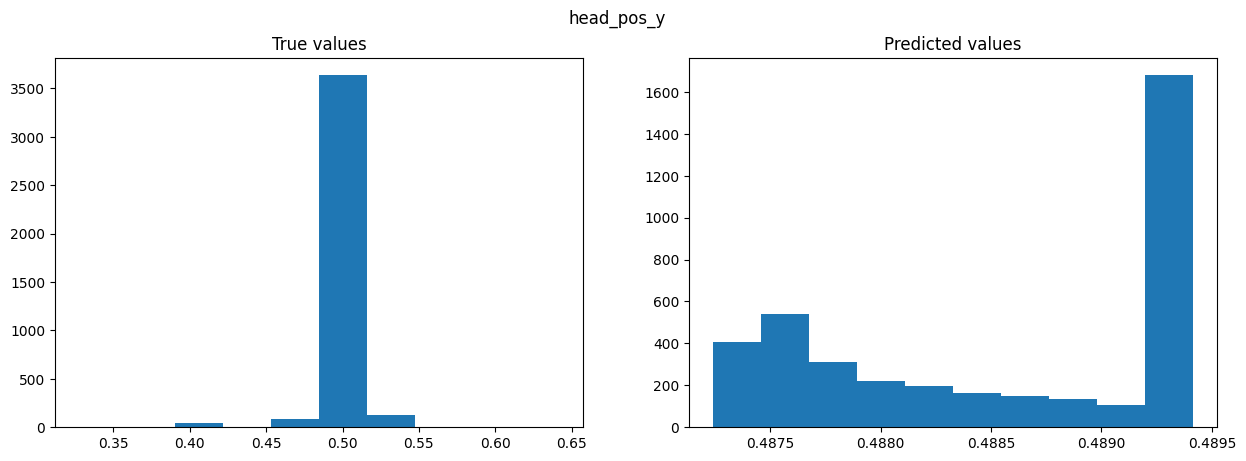

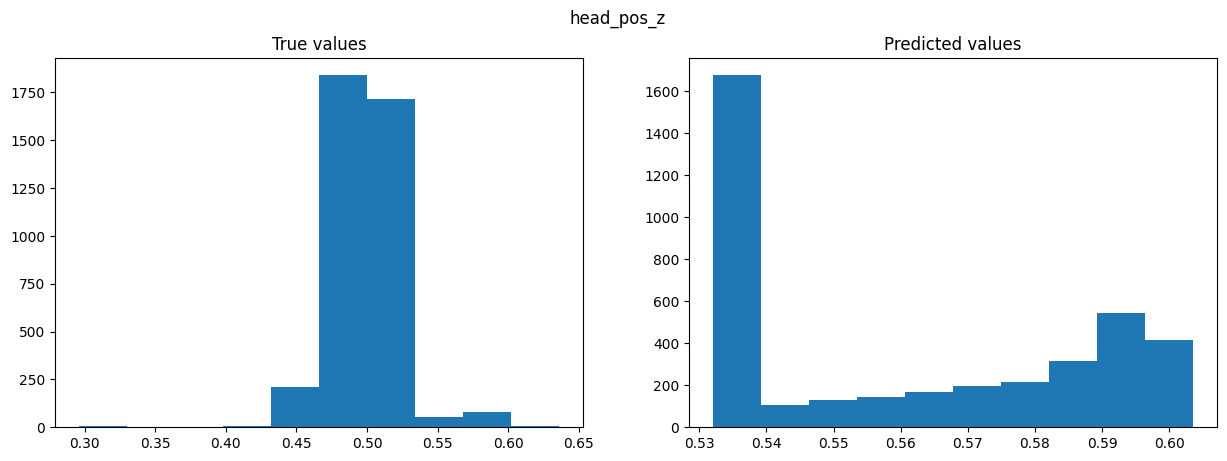

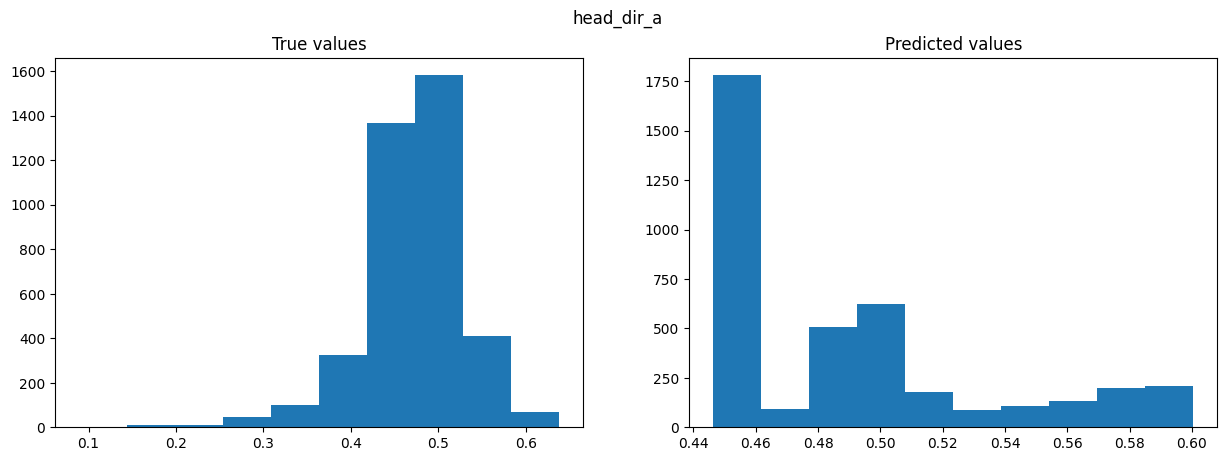

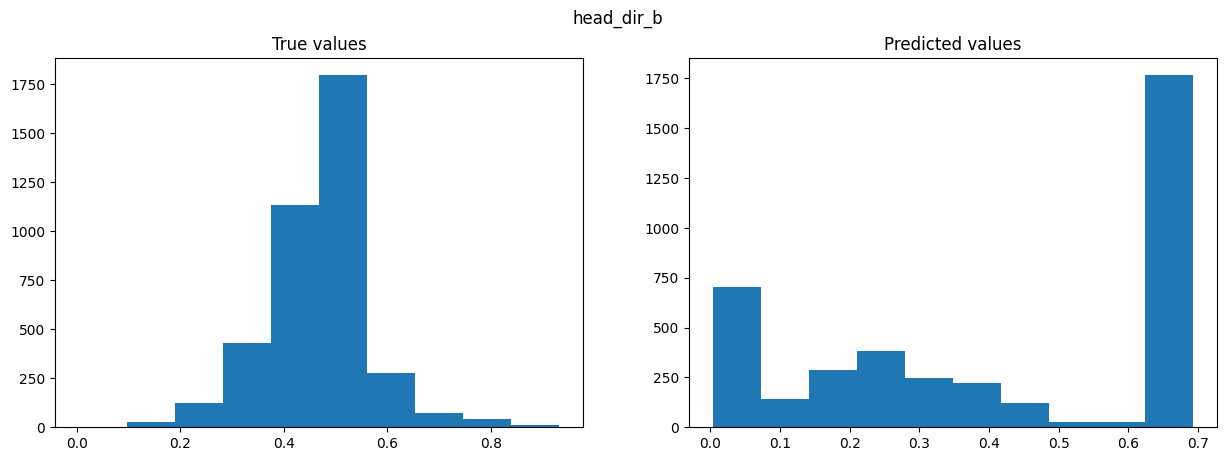

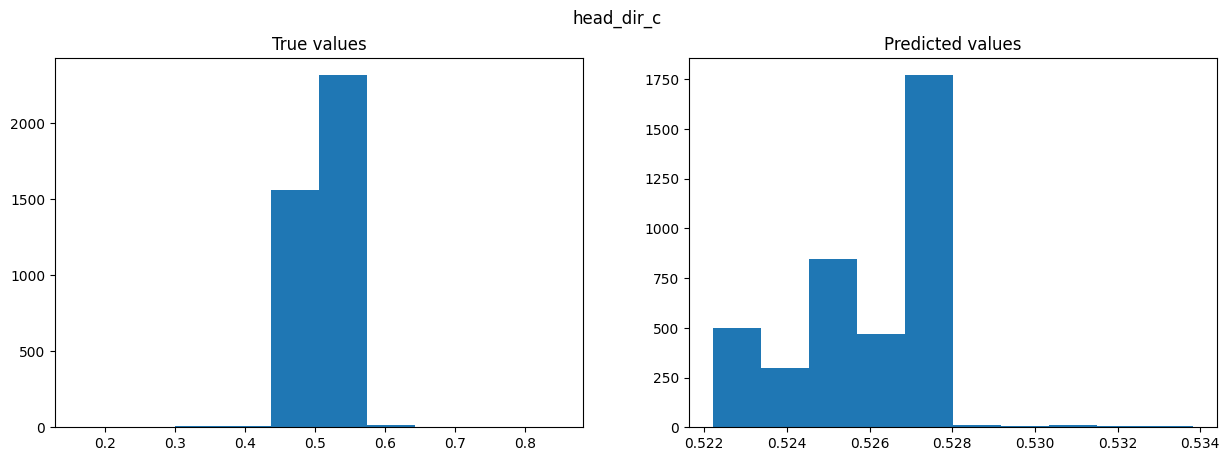

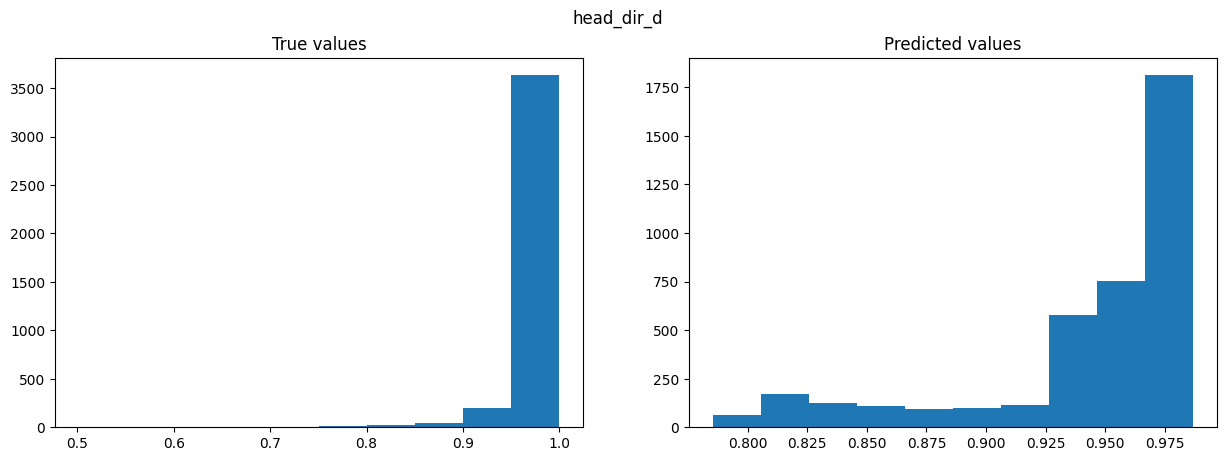

In [26]:
###################### Visualise distributions of each control ######################
true_dist = fin_true_df.iloc[:, 2:]
pred_dist = fin_pred_df.iloc[:, 2:]

for i in range(11):
    fig, axs = plt.subplots(nrows=1, ncols=2)
    fig.set_figwidth(15)
    fig.suptitle(col_pred[i])

    axs[0].hist(true_dist.iloc[:, i])
    axs[0].set_title('True values')

    axs[1].hist(pred_dist.iloc[:, i])
    axs[1].set_title('Predicted values')
    plt.show()

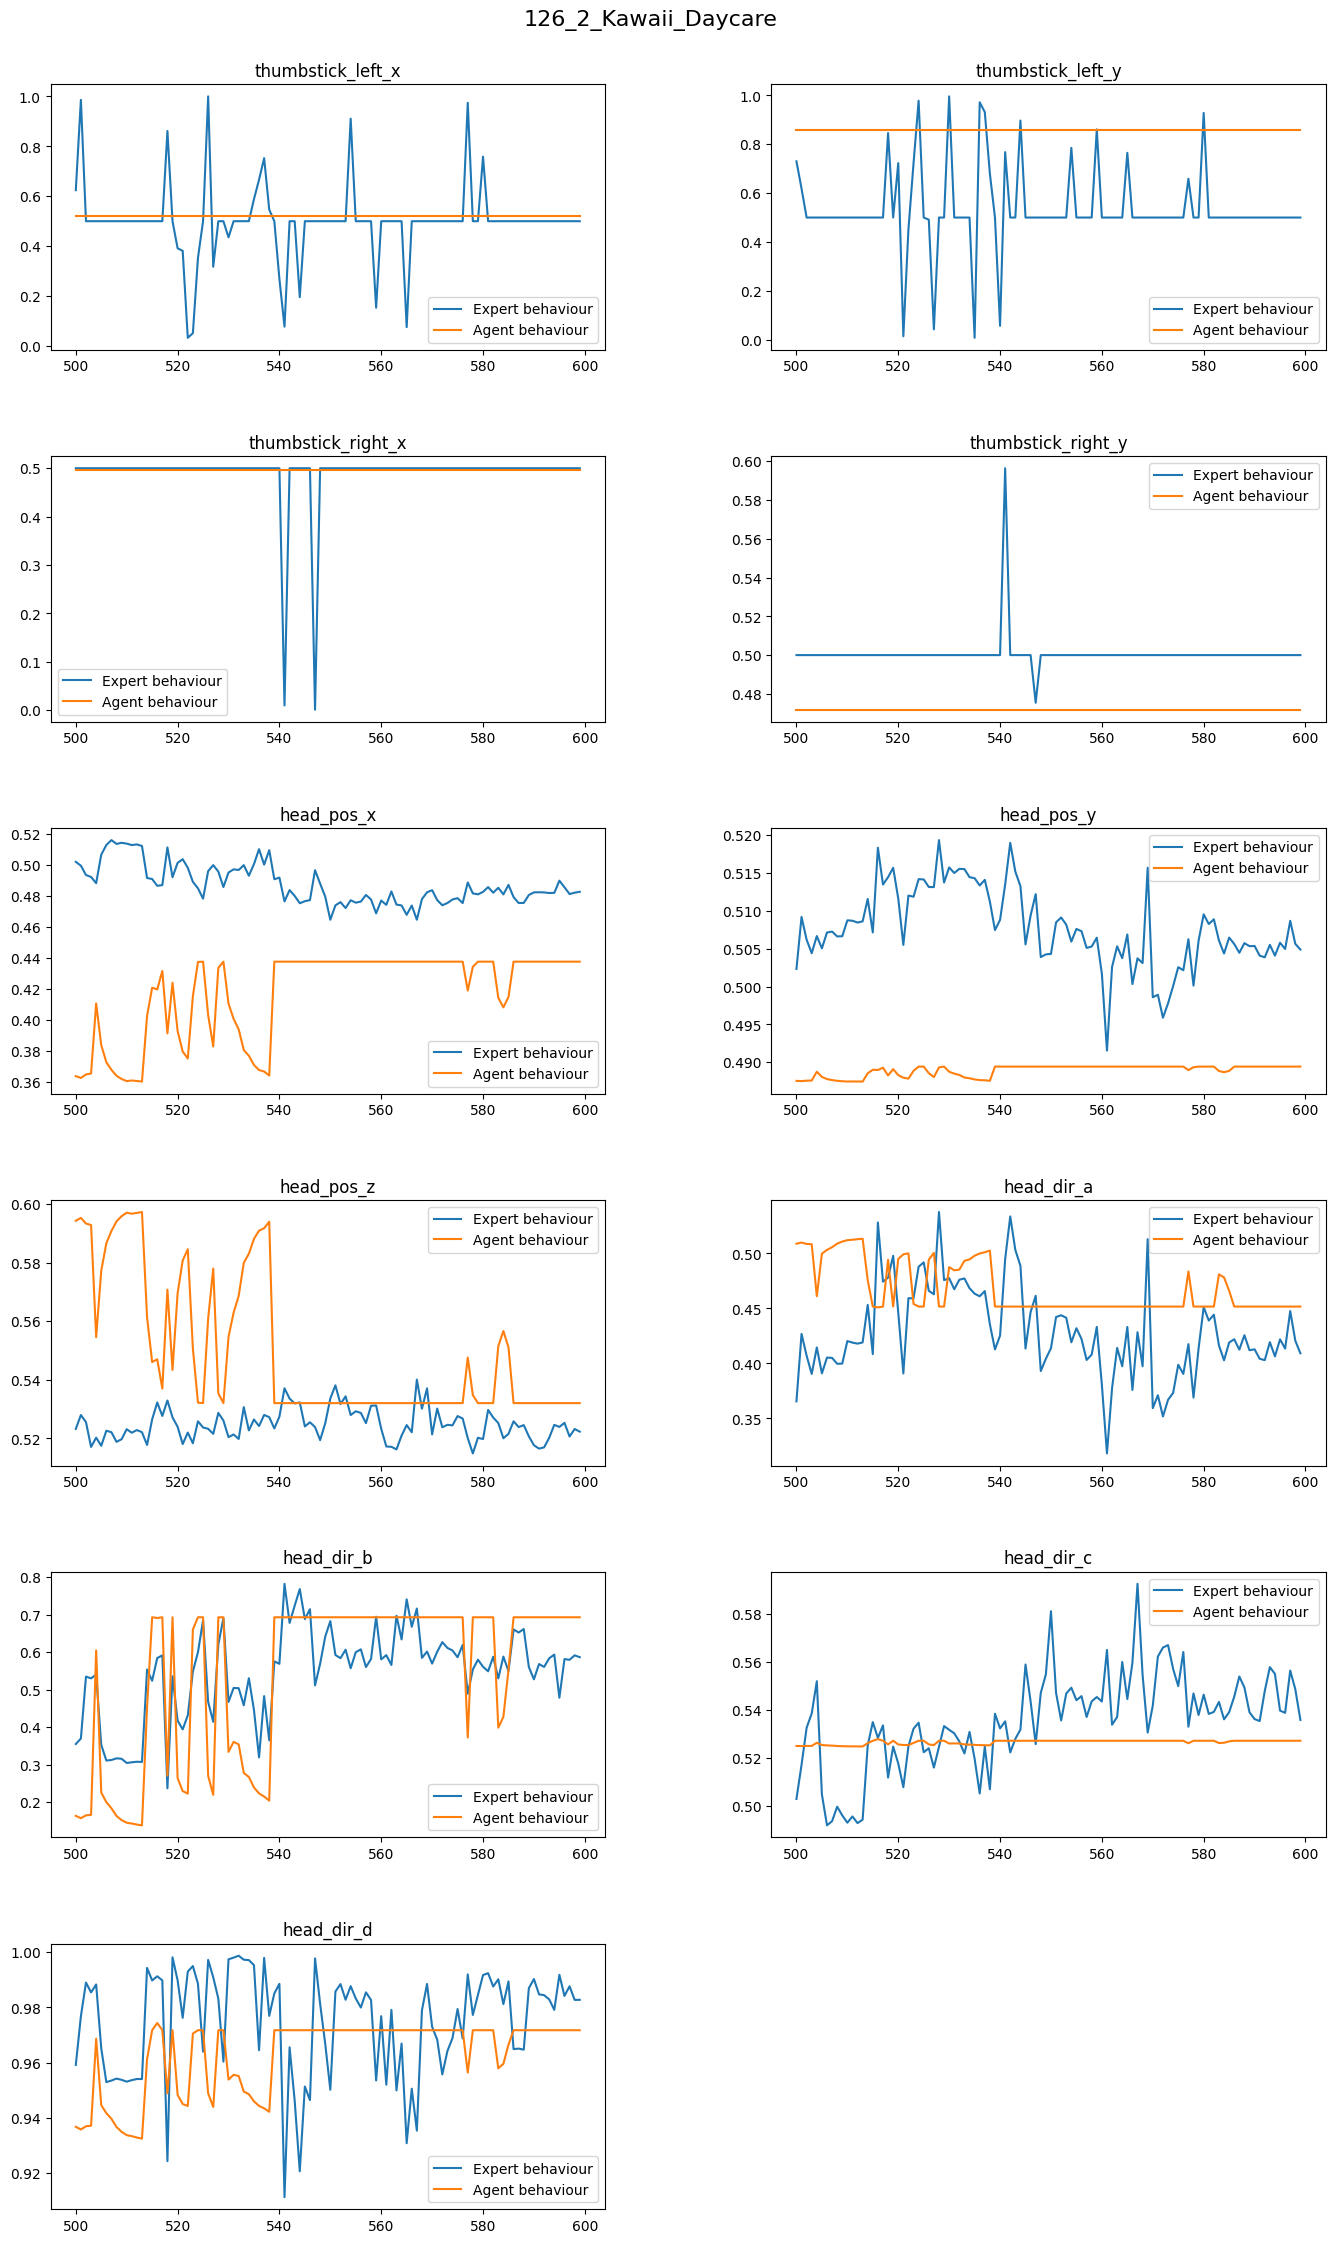

In [30]:
###################### Visualise behaviour given a sequence ######################
seq_ind = 5
seq_length = 100

true_seq = fin_true_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
pred_seq = fin_pred_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]

title = fin_true_df.iloc[seq_length*seq_ind, 0:2]

fig, axs = plt.subplots(nrows=6, ncols=2)
fig.set_figheight(25)
fig.set_figwidth(15)
fig.delaxes(axs[5,1])
fig.suptitle(title.iloc[0], size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

for i, ax in enumerate(axs.flat):
    if i == 11:
        break
    ax.plot(true_seq.iloc[:, i])
    ax.plot(pred_seq.iloc[:, i])
    ax.set_title(col_pred[i])
    ax.legend(['Expert behaviour', 'Agent behaviour'])

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.3, hspace=0.4)
plt.show()